# Markov Decision Process

A stationary discrete Markov Decision Process (MDP) is characterized by the tuple $(\mathcal{X},\mathcal{A},\mathbb{P},r,\gamma)$, where 

1. $\mathcal{X}$ is the (finite countable) set of states; 
2. $\mathcal{A}$ is the (finite countable) set of actions;
3. $P : \mathcal{X} \times \mathcal{A} \times \mathcal{X} \to [0,1]$ is the transition probability function, such that $P(x,a,x^+)$ is the probability of ending up in state $x^+ \in \mathcal{S}$ from state $x \in \mathcal{X}$ when taking action $a \in \mathcal{A}$;
4. $r : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ is the reward function, so that $r(x,x^+)$ returns the reward for 
transitioning from state $x \in \mathcal{X}$ to state $x^+ \in \mathcal{X}$;
5. $\gamma \in \mathbb{R}_{> 0}$ is a discount factor [1].

The aim is to find a policy, i.e., a function $\pi : \mathcal{S} \to \mathcal{A}$, returning the best action for any given state. A solution concept for MDP is the *value function*, $v^{\pi} : \mathcal{S} \to \mathbb{R}$, defined as
$$
\begin{equation}
    \label{eq:bellman}
    v^{\pi}(x) = \overbrace{\sum_{x^+ \in \mathcal{X}} P(x,\pi(x),x^+) \left( r(x,x^+) + \gamma v(x^+) \right)}^{=:\mathsf{T}(v^{\pi})}
\end{equation}
$$

returning the "goodness" of policy $\pi$. The expression in $\eqref{eq:bellman}$ is known as *Bellman equation*, and can be expressed as an operator of $v^{\pi}$, i.e., $\mathsf{T}[v^\pi(s)] =: \mathsf{T}(v^{\pi})$. It can be shown that the value function yielded by the optimal policy, $v^*$, results from the fixed-point problem $v^* = \mathsf{T}(v^*)$. Therefore, the latter can be formulated as a canonical VI, with $F = \mathsf{I} - \mathsf{T}$.

## References
[1] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

Using: eg
Using: popov
Using: fbf
Using: frb
Using: prg
Using: eag
Using: arg
Using: fogda
Using: graal
Using: agraal
Using: hgraal_1
Using: hgraal_2


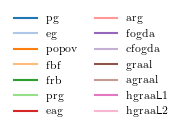

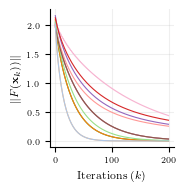

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from utils import *
from monviso import VI

np.random.seed(2024)

# Number of states and actions
num_X, num_A = 20, 10

# Discount factor
gamma = 0.8

# Transition probabilities
P = np.random.rand(num_X, num_A, num_X)
P /= P.sum(2, keepdims=True)

# Reward
R = np.random.rand(num_X, num_X)

# Bellman operator (as fixed point) and VI mapping
T = lambda v: np.einsum("ijk,ik -> ij", P, R + gamma * v[None, :]).max(1)
F = lambda x: x - T(x)
L = 3

# Create the VI and the initial solution(s)
mdp = VI(num_X, F)
x0 = [np.random.rand(num_X) for _ in range(2)]

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg", "cfogda"}).items():
    print(f"Using: {algorithm}")
    sol = mdp.solution(
        algorithm,
        params,
        max_iter,
        eval_func=lambda x: np.linalg.norm(F(x), 2),
        log_path=f"logs/markov-decision-process/{algorithm}.log",
    )

plot_results(
    "logs/markov-decision-process",
    "figs/markov-decision-process.pdf",
    r"$\|F(\mathbf{x}_k))\|$",
)
